# Product Recommendation Systems

## About the project:
    Domain: E-commerce
    Context: Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and improves conversion. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites.
    Data Description:
        Data columns: First three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.
        Source: Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/). The repository has several datasets. For this case study, we are using the Electronics dataset.
    Learning Outcomes: 
        ● Exploratory Data Analysis
        ● Data Wrangling
        ● Build a Popularity recommender model
        ● Build Collaborative Filtering model
    Objective: To make a recommendation system that recommends at least five(5) new products based on the user's habits.
    Solution by: 
        Developer: Kartik Thakkar
        Email: kartikthakkar@outlook.com
        Github: https://github.com/code-animator
        

## Solution:

In [45]:
#Importing the required libraries and read the source data
import numpy as np  
import pandas as pd
import seaborn as sns
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from collections import defaultdict

In [2]:
#Load and review the data
#For reference you may download the source data from http://jmcauley.ucsd.edu/data/amazon/ and save it before you execute this step.
inpdf=pd.read_csv('ratings_Electronics.csv')
inpdf.head(5)

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


#### Observation: The dataframe appears to have no column names. Let's add column names as per the data description.

In [3]:
# adding column name to the respective columns 
inpdf.columns =['userId', 'productId', 'rating', 'timestamp'] 

In [4]:
inpdf.shape

(7824481, 4)

In [5]:
inpdf.head(5)

,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [6]:
#sns.distplot(inpdf['rating'],kde=True,rug=True);

In [7]:
inpdf.drop('timestamp', axis=1, inplace=True)
inpdf.head()

,userId,productId,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [8]:
#Let's identify all columns having missing values
missing_values_cols=inpdf.columns[inpdf.isnull().any()]
# Number of missing values in each column
inpdf[missing_values_cols].isnull().sum()

Series([], dtype: float64)

In [9]:
#The dataframe does not appear to have any null values in any of the columns.
#Let's however look for negative ratings
inpdf[inpdf['rating']<0]

,userId,productId,rating


In [10]:
usr_drop_df=pd.DataFrame(inpdf.groupby('userId',as_index=False)['rating'].count())

In [11]:
usr_drop_df.sort_values(by='rating',ascending=False).head(10)

,userId,rating
3263531,A5JLAU2ARJ0BO,520
3512451,ADLVFFE4VBT8,501
2989526,A3OXHLG6DIBRW8,498
3291008,A6FIAB28IS79,431
3284634,A680RUE1FDO8B,406
755206,A1ODOGXEYECQQ8,380
2424036,A36K2N527TXXJN,314
1451394,A2AY4YUOX2N1BQ,311
4100926,AWPODHOB4GFWL,308
3935038,ARBKYIVNYWK3C,296


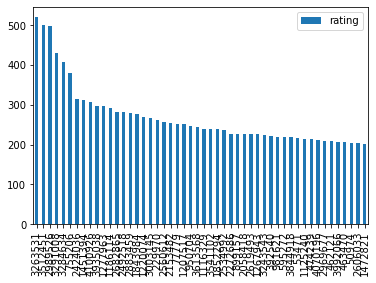

In [55]:
usr_drop_df.sort_values(by='rating',ascending=False).head(50).plot(kind='bar')

In [12]:
#let's identify user IDs that have rated less than 51 ratings to make the data sparser.
usr_drop_df_subset=usr_drop_df[usr_drop_df['rating']<51]
usr_drop_df_subset.sort_values(by='rating',ascending=False).head(10)

,userId,rating
2863870,A3KTWUXXB8KKC7,50
4144325,AY4EXFOO43C3S,50
1607151,A2FZQF0MH29VYN,50
4035718,AULFLNWJP1QXY,50
243139,A17RFKCYS69M3Y,50
456147,A1EOTB1WHLSW6G,50
2205403,A2ZGDHLJ85T6AD,50
952932,A1USYP4AXF5I1D,50
3574203,AFM7FK7NFEKFZ,50
1168296,A21S26XYPGXJZX,50


In [13]:
usr_drop_df_subset.columns

Index(['userId', 'rating'], dtype='object')

In [14]:
usr_drop_df_subset.shape

(4200230, 2)

In [15]:
usr_drop_list_subset=usr_drop_df_subset['userId'].tolist()
inpdf1 = inpdf[~inpdf['userId'].isin(usr_drop_list_subset)]

In [16]:
inpdf1.shape

(122171, 3)

In [17]:
inpdf1.head()

,userId,productId,rating
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0
630,A3TAS1AG6FMBQW,0972683275,5.0


### Let's build a polpularity based recommendation system

In [18]:
inpdf1.groupby('productId')['rating'].mean().sort_values(ascending=False).head(10)

productId
B00LKG1MC8    5.0
B000H8WLKC    5.0
B000HA4EZK    5.0
B004EHZZDW    5.0
B004EI0EG4    5.0
B000H9J3WA    5.0
B004EK9ODG    5.0
B004EKEBNY    5.0
B004EKEF0S    5.0
B004EKOCSS    5.0
Name: rating, dtype: float64

In [19]:
inpdf1.groupby('productId')['rating'].count().sort_values(ascending=False).head(10)

productId
B0088CJT4U    204
B003ES5ZUU    177
B000N99BBC    163
B007WTAJTO    156
B00829TIEK    146
B008DWCRQW    135
B00829THK0    132
B002R5AM7C    127
B004CLYEDC    117
B004T9RR6I    108
Name: rating, dtype: int64

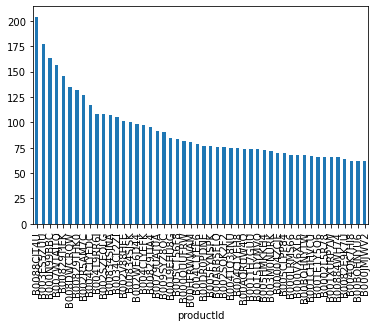

In [53]:
inpdf1.groupby('productId')['rating'].count().sort_values(ascending=False).head(50).plot(kind = "bar")

In [20]:
mean_rating=pd.DataFrame(inpdf1.groupby('productId')['rating'].mean())
mean_rating.head()

,rating
productId,
0594481813,3.0
0970407998,2.5
0972683275,5.0
1400501466,3.0
1400501520,5.0


In [21]:
mean_rating['count_of_ratings']=pd.DataFrame(inpdf1.groupby('productId')['rating'].count())
mean_rating.head()

,rating,count_of_ratings
productId,,
0594481813,3.0,1
0970407998,2.5,2
0972683275,5.0,3
1400501466,3.0,5
1400501520,5.0,1


In [22]:
pop_recomm=pd.DataFrame(mean_rating.sort_values(by=['rating','count_of_ratings'],ascending=False))
pop_recomm.head(100)

,rating,count_of_ratings
productId,,
B000FQ2JLW,5.0,18
B00ISFNSBW,5.0,18
B000IJY8DS,5.0,17
B001TH7GUA,5.0,17
B00HZWJGS8,5.0,17
...,...,...
B005J31BCY,5.0,7
B005J4C820,5.0,7
B005LJQMCK,5.0,7


### Splitting data in to test and training set and collab filtering.

In [23]:
inpdf1.shape

(122171, 3)

In [24]:
inpdf1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122171 entries, 117 to 7824443
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     122171 non-null  object 
 1   productId  122171 non-null  object 
 2   rating     122171 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.7+ MB


In [25]:
#Given the number of records is high, to avoid getting a memory allocation error, we will go ahead with 10% of the samples instead of proceeding ahead with the entire set.
inpdf1_sample=inpdf1.sample(frac=0.10)

In [26]:
inpdf1_sample.shape

(12217, 3)

In [27]:
#Let's move ahead with collab filtering. We will implement both - item-item based and user-user based collab filtering
#Splitting the data into training and test set with a split of 70/30.
max_rating=inpdf1_sample['rating'].max()
min_rating=inpdf1_sample['rating'].min()
print(min_rating,max_rating)

1.0 5.0


In [28]:
reader = Reader(rating_scale=(min_rating, max_rating))
indata = Dataset.load_from_df(inpdf1_sample,reader)
trainset, testset = train_test_split(indata, test_size=.30)

In [29]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
ibcf_algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
ibcf_algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [30]:
test_pred = ibcf_algo.test(testset)

In [31]:
test_pred

[Prediction(uid='A2VAD79S4A06DD', iid='B00196757K', r_ui=5.0, est=4.2440650216348965, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1VLE2SH9J8WYS', iid='B0015DYMVO', r_ui=5.0, est=4.6, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1R76R4E6A8S3B', iid='B004UEPUVG', r_ui=4.0, est=4.2440650216348965, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AWNJAY0M5UI70', iid='B001C4ETU0', r_ui=5.0, est=3.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AVPNQUVZWMDSX', iid='B0031GK3OI', r_ui=5.0, est=5.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2F92M62KN324B', iid='B001H0BA24', r_ui=4.0, est=4.2440650216348965, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AR18DH5SL9F73', iid='B008XVAVAW', r_ui=2.0, est=4.2440650216348965, details={'was_impossible': True, 'reason': 'User and/or item i

In [32]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.1598


1.1598134358663916

In [2]:
#The model's performance is poor given that the RMSE is 1.1598.
#Considering that only 10% of the data set has been used and majority of the predictions were impossible, try running this with 100% of the dataset to verify performance of the model. 

### Let's get to recommend 5 products to each user based on his/her habit.

In [34]:
#Given the number of records is high, to avoid getting a memory allocation error, we will go ahead with 1% of the samples instead of proceeding ahead with the entire set.
#inpdf1_sample1=inpdf1.sample(frac=0.10)
#max_rating=inpdf1['rating'].max()
#min_rating=inpdf1['rating'].min()
#print(min_rating,max_rating)
#reader1 = Reader(rating_scale=(min_rating, max_rating))
#matf_indata = Dataset.load_from_df(inpdf1,reader1)
#matf_indata=indata

#Given the number of records is high, to avoid getting a memory allocation error, we will go ahead with 1% of the samples instead of proceeding ahead with the entire set.
inpdf2_sample=inpdf1.sample(frac=0.01)
max_rating=inpdf2_sample['rating'].max()
min_rating=inpdf2_sample['rating'].min()
reader1 = Reader(rating_scale=(min_rating, max_rating))
matf_indata = Dataset.load_from_df(inpdf2_sample,reader1)

In [35]:
matf_indata

In [36]:
trainset1=matf_indata.build_full_trainset()

In [37]:
trainset1.ur

defaultdict(list,
            {0: [(0, 4.0), (251, 4.0), (901, 5.0)],
             1: [(1, 5.0)],
             2: [(2, 5.0)],
             3: [(3, 5.0), (95, 4.0), (203, 4.0), (599, 2.0), (825, 3.0)],
             4: [(4, 5.0), (700, 5.0), (112, 3.0)],
             5: [(5, 5.0), (291, 4.0)],
             6: [(6, 4.0),
              (70, 5.0),
              (217, 4.0),
              (510, 5.0),
              (535, 5.0),
              (689, 5.0),
              (1127, 4.0)],
             7: [(7, 5.0), (655, 1.0)],
             8: [(8, 4.0), (470, 5.0)],
             9: [(9, 3.0), (486, 5.0), (898, 5.0), (919, 5.0), (1108, 2.0)],
             10: [(10, 4.0)],
             11: [(11, 5.0)],
             12: [(12, 1.0), (401, 5.0), (791, 5.0), (1149, 1.0)],
             13: [(13, 4.0), (44, 3.0), (879, 4.0)],
             14: [(14, 2.0)],
             15: [(15, 5.0), (549, 5.0)],
             16: [(16, 5.0), (85, 5.0)],
             17: [(17, 5.0), (847, 4.0), (1158, 5.0)],
             18: [

In [38]:
matf_algo = SVD()
matf_algo.fit(trainset1)

In [39]:
# Let's predict ratings for all pairs (u, i) that are NOT in the training set.
testset1 = trainset1.build_anti_testset()

In [40]:
matf_predictions = matf_algo.test(testset1)

In [41]:
matf_predictions

[Prediction(uid='A18HE80910BTZI', iid='B00005U21H', r_ui=4.286415711947627, est=4.306601723782475, details={'was_impossible': False}),
 Prediction(uid='A18HE80910BTZI', iid='B00BW6KCTU', r_ui=4.286415711947627, est=4.410738787230967, details={'was_impossible': False}),
 Prediction(uid='A18HE80910BTZI', iid='B00JGGUZRC', r_ui=4.286415711947627, est=4.264237646053632, details={'was_impossible': False}),
 Prediction(uid='A18HE80910BTZI', iid='B002S0OBV4', r_ui=4.286415711947627, est=4.31894826335416, details={'was_impossible': False}),
 Prediction(uid='A18HE80910BTZI', iid='B0001VQ11U', r_ui=4.286415711947627, est=4.3761268248031335, details={'was_impossible': False}),
 Prediction(uid='A18HE80910BTZI', iid='B000U8YZC6', r_ui=4.286415711947627, est=4.364896365253024, details={'was_impossible': False}),
 Prediction(uid='A18HE80910BTZI', iid='B006DEBYWU', r_ui=4.286415711947627, est=4.368737074895185, details={'was_impossible': False}),
 Prediction(uid='A18HE80910BTZI', iid='B004N6ZC8W', r_u

In [47]:
def get_top_n(matf_predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in matf_predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [48]:
top_n = get_top_n(matf_predictions, n=5)

In [49]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A18HE80910BTZI ['B001S4OTS6', 'B000R9AAJA', 'B00004Z5KZ', 'B003ES5ZUU', 'B00E5N9ONM']
A3BI8BKIHESDNQ ['B0032JPDFI', 'B00EN27TCI', 'B005KG44V0', 'B001D60LG8', 'B00AWKC0EC']
A11OTLEDSW8ZXD ['B0049XGNKK', 'B0007QKMQY', 'B007NZGPAY', 'B005WXQO3W', 'B00134LUE2']
A6VXZ1EEPRTLV ['B001D60LG8', 'B004HKIB6E', 'B0090Z3QG6', 'B000063TJY', 'B000I98ZW8']
A2OBDNQ5ZYU1L8 ['B00AWKC0EC', 'B0030MIU16', 'B002AEU3EW', 'B0017TFVUW', 'B004N625BO']
A1VVRA3P6G1TWH ['B00427TAIK', 'B0068MSGZA', 'B002WE6D44', 'B00IVPU7DG', 'B00EEA8T64']
A1EVV74UQYVKRY ['B00005V619', 'B00829TIA4', 'B00009R89A', 'B000TM1O3Q', 'B000F2YHKM']
A3R19YKNL641X3 ['B007BJC75E', 'B0001MKU4S', 'B00EMB4LU8', 'B004M8ST2W', 'B004MPQY9A']
A1BT6TL7UCIC5Y ['B008U3038I', 'B000R99GJ0', 'B004GF8TIK', 'B005WXQO3W', 'B002BH4PW4']
AT28RL25Q2OLK ['B004SHL4KQ', 'B00I9V8D92', 'B00FW6T36Y', 'B003ES5ZUU', 'B00BHZTPTY']
A2D1ZQEFS1NBH2 ['B003VANOI6', 'B00009W3IB', 'B002C74E9C', 'B003LSTD38', 'B009W34X5O']
A3S0EHEIR52HP1 ['B00FW6T36Y', 'B00829TIA4', 'B001E96JBK'

In [50]:
# get RMSE
print("Matrix Factorization : Test Set")
accuracy.rmse(matf_predictions, verbose=True)

Matrix Factorization : Test Set
RMSE: 0.1734


0.17338047613836727

In [51]:
#The RMSE score indicate that the model performance is good.
#Even with 1% dataset it is possible to recommend products based on user reviewing patterns.
#However, with 10% of data from the data set recommendation based on products being considered/viewed/reviewed, the model could not perform well enough.
#Goes to show that collaborative filtering (item-item or user-user) may be used based on modelling of a significant amount of the dataset.
#Popularity based could be used as a lot of products have been rated by distinct users.